# Compute ADR for ROMY Array

compute adr for romy array stations

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np

from obspy.clients.fdsn import Client


In [2]:
from functions.makeplot_spectra_comparison_fill import __makeplot_spectra_comparison_fill

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [4]:
def __write_stream_to_sds(st, path_to_sds):

    import os

    # check if output path exists
    if not os.path.exists(path_to_sds):
        print(f" -> {path_to_sds} does not exist!")
        return

    for tr in st:

        nn, ss, ll, cc = tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel
        yy, jj = tr.stats.starttime.year, str(tr.stats.starttime.julday).rjust(3,"0")

        if not os.path.exists(path_to_sds+f"{yy}/"):
            os.mkdir(path_to_sds+f"{yy}/")
            print(f"creating: {path_to_sds}{yy}/")
        if not os.path.exists(path_to_sds+f"{yy}/{nn}/"):
            os.mkdir(path_to_sds+f"{yy}/{nn}/")
            print(f"creating: {path_to_sds}{yy}/{nn}/")
        if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/"):
            os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/")
            print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/")
        if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D"):
            os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D")
            print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/{cc}.D")

        st.write(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D/"+f"{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}", format="MSEED")

        print(f" -> stored stream as: {yy}/{nn}/{ss}/{cc}.D/{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}")

In [5]:
def __compute_romy_adr(tbeg, tend, submask='all', ref_station='GR.FUR', excluded_stations=[], map_plot=False, verbose=False):

    """
    rotation_X = -u_nz
    rotation_Y =  u_ez
    rotation_Z = 0.5*(u_ne-u_en)
    """

    # load modules
    import os
    import numpy as np
    import timeit
    import matplotlib.pyplot as plt
    import matplotlib.colors

    from obspy import UTCDateTime, Stream, read_inventory
    from obspy.clients import fdsn
    from obspy.geodetics.base import gps2dist_azimuth
    from obspy.geodetics import locations2degrees
    from obspy.clients.fdsn import Client, RoutingClient
    from obspy.signal import array_analysis as AA
    from obspy.signal.util import util_geo_km
    from obspy.signal.rotate import rotate2zne
    from datetime import datetime

    import warnings
    warnings.filterwarnings('ignore')

    # specify paths
    if os.uname().nodename == 'lighthouse':
        root_path = '/home/andbro/'
        data_path = '/home/andbro/kilauea-data/'
        archive_path = '/home/andbro/freenas/'
        bay_path = '/home/andbro/bay200/'
    elif os.uname().nodename == 'kilauea':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/bay200/'
    elif os.uname().nodename == 'lin-ffb-01':
        root_path = '/home/brotzer/'
        data_path = '/import/kilauea-data/'
        archive_path = '/import/freenas-ffb-01-data/'
        bay_path = '/bay200/'

    # _____________________________________________________

    # start timer for runtime
    start_timer = timeit.default_timer()

    # _____________________________________________________

    # generate configuration object
    config = {}

    # change to UTCDateTime object
    config['tbeg'] = UTCDateTime(tbeg)
    config['tend'] = UTCDateTime(tend)

    # select the fdsn client for the stations
    config['fdsn_client'] = {"BW":Client('http://jane'), "GR":Client('BGR')}

    # define output seed
    config['out_seed'] = "BW.ROMY"

    # add submask
    config['submask'] = submask

    # specify location codes for subarrays
    if config['submask'] == "inner":
        config['location'] = "21"
    elif config['submask'] == "outer":
        config['location'] = "22"
    elif config['submask'] == "all":
        config['location'] = "23"

    # select stations to consider:
    if submask is not None:

        if submask == "inner":
            config['subarray_mask'] = [0, 1, 2, 3]
            config['freq1'] = 0.2
            config['freq2'] = 1.0

        elif submask == "outer":
            config['subarray_mask'] = [0, 4, 5, 6, 7, 8]
            config['freq1'] = 0.01
            config['freq2'] = 0.1

        elif submask == "all":
            config['subarray_mask'] = [0, 1, 2, 3, 4, 5, 6, 7, 8]
            config['freq1'] = 0.01
            config['freq2'] = 0.1

    # decide if information is printed while running the code
    config['verbose'] = verbose

    # specify reference station (where to compute adr)
    config['reference_station'] = ref_station

    # ROMY array station information
    config['array_stations'] = ['GR.FUR', 'BW.FFB1', 'BW.FFB2', 'BW.FFB3',
                                'BW.BIB', 'BW.TON', 'BW.GELB', 'BW.ALFT', 'BW.GRMB',
                               ]

    # select stations of subarray
    config['subarray_stations'] = []
    for i in config['subarray_mask']:
        if config['array_stations'][i] not in excluded_stations:
            config['subarray_stations'].append(config['array_stations'][i])

    # specify if bandpass is applied to data
    # config['prefilt'] = (0.001, 0.01, 5, 10)
    config['apply_bandpass'] = False

    # adr parameters
    config['vp'] = 1 # 5000 #6264. #1700
    config['vs'] = 1 # 3500 #3751. #1000
    config['sigmau'] = 1e-7 # 0.0001

    # _____________________________________________________

    def __check_samples_in_stream(st, config):

        Rnet, Rsta = config['reference_station'].split(".")

        Rsamples = st.select(network=Rnet, station=Rsta)[0].stats.npts

        for tr in st:
            if tr.stats.npts != Rsamples:
                print(f" -> removing {tr.stats.station} due to improper number of samples ({tr.stats.npts} not {Rsamples})")
                st.remove(tr)

        return st

    def __get_data(config):

        config['subarray'] = []

        st = Stream()

        coo = []

        for k, station in enumerate(config['subarray_stations']):

            net, sta = station.split(".")

            loc, cha = "", "BH*"

            # modify time interval
            t1, t2 = config['tbeg']-3600, config['tend']+3600

            # querry inventory data
            try:
                try:
                    # load local version
                    inventory = read_inventory(data_path+f"stationxml_ringlaser/station_{net}.{sta}.xml")

                    if config['verbose']:
                        print(f" -> load local inventory for {net}.{sta} ...")

                except:
                    if sta == "FUR":
                            inventory = read_inventory(data_path+f"stationxml_ringlaser/station_{net}_{sta}.xml")
                    else:
                        inventory = config['fdsn_client'][net].get_stations(
                                                                            network=net,
                                                                            station=sta,
                                                                            location=loc,
                                                                            channel=cha,
                                                                            starttime=t1,
                                                                            endtime=t2,
                                                                            level="response"
                                                                            )
                    if config['verbose']:
                        print(f" -> load jane inventory {net}.{sta} ...")

            except:
                print(f" -> failed to load inventory for {net}.{sta} ...!")
                inventory = None

            # add coordinates
            l_lon = float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['longitude'])
            l_lat = float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['latitude'])
            height = float(inventory.get_coordinates('%s.%s.%s.%sZ'%(net,sta,loc,cha[:2]))['elevation'])

            # store reference coordinates
            if sta == config['reference_station'].split(".")[1]:
                o_lon, o_lat, o_height = l_lon, l_lat, height

            # compute relative distances to reference station in km
            lon, lat = util_geo_km(o_lon, o_lat, l_lon, l_lat)

            # store distances as meters
            coo.append([lon*1000, lat*1000, height-o_height])

            # try to get waveform data
            try:

                # load waveforms for station
                stats = config['fdsn_client'][net].get_waveforms(
                                                                network=net,
                                                                station=sta,
                                                                location=loc,
                                                                channel=cha,
                                                                starttime=config['tbeg']-3600,
                                                                endtime=config['tend']+3600,
                                                                attach_response=False,
                                                                )
            except Exception as e:
                print(e)
                print(f" -> failed to load waveforms for {net}.{sta} ...")
                config['stations_loaded'][k] = 0
                continue

            # merge if masked
            if len(stats) > 3:
                print(f" -> merging stream. Length: {len(stats)} -> 3") if config['verbose'] else None
                stats.merge(method=1, fill_value="interpolate")

            # successfully obtained
            if len(stats) == 3:
                if config['verbose']:
                    print(f" -> obtained waveforms for {net}.{sta}")

            # remove response [VEL -> rad/s | DISP -> rad]
            stats = stats.remove_sensitivity(inventory)
            # stats = stats.remove_response(inventory, output="VEL", water_level=None, pre_filt=[0.005, 0.008, 8, 10])
            # stats = stats.remove_response(inventory, output="VEL", water_level=1)

            # rotate to ZNE
            try:
                if sta in ["FFB1", "FFB2", "FFB3"]:
                    stats = stats.rotate(method='->ZNE', inventory=inventory, components=['Z12'])
                else:
                    stats = stats.rotate(method='->ZNE', inventory=inventory, components=['ZNE'])
            except:
                print(f" -> failed to rotate to ZNE for {net}.{sta}")
                continue

            # resampling using decitmate
            stats = stats.detrend("linear");
            stats = stats.detrend("simple");

            # stats = stats.taper(0.01);
            stats = stats.filter("highpass", freq=0.001, corners=4, zerophase=True);
            # stats = stats.filter("highpass", freq=0.001);

            # resample to output sampling rate
            if sta in ["FFB1", "FFB2", "FFB3"]:
                stats = stats.decimate(2, no_filter=False)

            # store stream of reference station as template
            if station == config['reference_station']:
                ref_station = stats.copy()

            stats = stats.trim(t1, t2)

            # add station data to stream
            st += stats

            # update subarray
            config['subarray'].append(f"{stats[0].stats.network}.{stats[0].stats.station}")

            if config['verbose']:
                print(stats)

        # trim to interval
        # stats.trim(config['tbeg'], config['tend'], nearest_sample=False)

        # convert to array object
        config['coo'] = np.array(coo)

        config['subarray_stations'] = config['subarray']

        if config['verbose']:
            print(f" -> obtained: {int(len(st)/3)} of {len(config['subarray_stations'])} stations!")

        # check for reference station
        if config['reference_station'] not in config['subarray_stations']:
            print(f" -> reference station not in station set!!!")
            return st, Stream(), config

        if len(st) == 0:
            return st, Stream(), config
        else:
            return st, ref_station, config

    def __compute_ADR(st, config, ref_station):

        # prepare data arrays
        tsz, tsn, tse = [], [], []
        for tr in st:
            try:
                if "Z" in tr.stats.channel:
                    tsz.append(tr.data)
                elif "N" in tr.stats.channel:
                    tsn.append(tr.data)
                elif "E" in tr.stats.channel:
                    tse.append(tr.data)
            except:
                print(" -> stream data could not be appended!")

        # make sure input is array type
        tse, tsn, tsz = np.array(tse), np.array(tsn), np.array(tsz)

        # define array for subarray stations with linear numbering
        substations = np.arange(len(config['subarray_stations']))

        try:
            result = AA.array_rotation_strain(substations,
                                              np.transpose(tse),
                                              np.transpose(tsn),
                                              np.transpose(tsz),
                                              config['vp'],
                                              config['vs'],
                                              config['coo'],
                                              config['sigmau'],
                                             )

        except Exception as e:
            print(e)
            print("\n -> failed to compute ADR ...")
            return None

        # create rotation stream and add data
        rotsa = ref_station.copy()

        rotsa[0].data = result['ts_w3']
        rotsa[1].data = result['ts_w2']
        rotsa[2].data = result['ts_w1']

        rotsa[0].stats.channel='BJZ'
        rotsa[1].stats.channel='BJN'
        rotsa[2].stats.channel='BJE'

        rotsa[0].stats.station=config['out_seed'].split(".")[1]
        rotsa[1].stats.station=config['out_seed'].split(".")[1]
        rotsa[2].stats.station=config['out_seed'].split(".")[1]

        rotsa[0].stats.network=config['out_seed'].split(".")[0]
        rotsa[1].stats.network=config['out_seed'].split(".")[0]
        rotsa[2].stats.network=config['out_seed'].split(".")[0]

        rotsa[0].stats.location=config['location']
        rotsa[1].stats.location=config['location']
        rotsa[2].stats.location=config['location']

        rotsa = rotsa.detrend('linear')

    #     gradient_ZNE = result['ts_ptilde'] #u1,1 u1,2 u1,3 u2,1 u2,2 u2,3
    #     u_ee=gradient_ZNE[:,0]
    #     u_en=gradient_ZNE[:,1]
    #     u_ez=gradient_ZNE[:,2]
    #     u_ne=gradient_ZNE[:,3]
    #     u_nn=gradient_ZNE[:,4]
    #     u_nz=gradient_ZNE[:,5]


        #(Gradient trace)
        #      Gradient = o_stats.copy()        #information of the central station
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient.append(o_stats[0].copy())
        #      Gradient[0].data = u_ee
        #      Gradient[1].data = u_en
        #      Gradient[2].data = u_ez
        #      Gradient[3].data = u_ne
        #      Gradient[4].data = u_nn
        #      Gradient[5].data = u_nz
        #      Gradient[0].stats.channel='uee'
        #      Gradient[1].stats.channel='uen'
        #      Gradient[2].stats.channel='uez'
        #      Gradient[3].stats.channel='une'
        #      Gradient[4].stats.channel='unn'
        #      Gradient[5].stats.channel='unz'

        return rotsa

    def __adjust_time_line(st0, reference="GR.FUR"):

        Rnet, Rsta = reference.split(".")

        ref_start = st0.select(network=Rnet, station=Rsta)[0].stats.starttime
        ref_times = st0.select(network=Rnet, station=Rsta)[0].times()

        dt = st0.select(network=Rnet, station=Rsta)[0].stats.delta

        for tr in st0:
            times = tr.times(reftime=ref_start)

            tr.data = np.interp(ref_times, times, tr.data)
            tr.stats.starttime = ref_start

        return st0

    # __________________________________________________________
    # MAIN

    # launch a times
    start_timer1 = timeit.default_timer()

    # status of stations loaded
    config['stations_loaded'] = np.ones(len(config['subarray_stations']))

    # request data for pfo array
    st, ref_station, config = __get_data(config)

    # processing
    st = st.detrend("linear")
    st = st.detrend("demean")

    # bandpass filter
    if config['apply_bandpass']:
        st = st.taper(0.02, type="cosine")
        st = st.filter('bandpass', freqmin=config['freq1'], freqmax=config['freq2'], corners=4, zerophase=True)
        print(f" -> bandpass: {config['freq1']} - {config['freq2']} Hz")

    ## plot station coordinates for check up
    if map_plot:
        stas = []
        for tr in st:
            if tr.stats.station not in stas:
                stas.append(tr.stats.station)

        # make checkup plot
        import matplotlib.pyplot as plt
        plt.figure()
        for c, s in zip(config['coo'], stas):
            if config['verbose']:
                print(s, c)
            plt.scatter(c[0], c[1], label=s)
            plt.legend()
        plt.show();

    # check if enough stations for ADR are available otherwise continue
    if len(st) < 9:
        print(" -> not enough stations (< 3) for ADR computation!")
        return
    else:
        if config['verbose']:
            print(f" -> continue computing ADR for {int(len(st)/3)} of {len(config['subarray_mask'])} stations ...")

    # homogenize the time line
    st = __adjust_time_line(st, reference=config['reference_station'])

    # check for same amount of samples
    __check_samples_in_stream(st, config)

    # compute array derived rotation (ADR)
    try:
        rot = __compute_ADR(st, config, ref_station)
    except Exception as e:
        print(e)
        return None, None

    # trim to requested interval
    rot = rot.trim(config['tbeg'], config['tend'])

    # stop times
    stop_timer1 = timeit.default_timer()
    print(f"\n -> Runtime: {round((stop_timer1 - start_timer1)/60, 2)} minutes\n")

    return rot

In [6]:
def __makeplot_ADR(st1, st2, x, freq=[0.01, 0.5], flog=False, fill=False):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd
    from functions.get_fft import __get_fft
    from functions.variance_reduction import __variance_reduction
    from numpy import nanmin, nanmax

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100, 2)
        return pmax

    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/60, "min"

    times = st1.select(channel="*N")[0].times()

    Ncol, Nrow = 6, 13

    font = 12

    lw = 1

    scale, unit = 1e9, f"nrad/s"

    fig = plt.figure(figsize=(15, 12))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)
    gs2 = GridSpec(Nrow, Ncol, figure=fig, hspace=10000)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])
    ax3 = fig.add_subplot(gs[3:5, :])
    ax4 = fig.add_subplot(gs[5, :])
    ax5 = fig.add_subplot(gs[6:8, :])
    ax6 = fig.add_subplot(gs[8, :])

    ax7 = fig.add_subplot(gs2[9:12, 0:2])
    ax8 = fig.add_subplot(gs2[9:12, 2:4])
    ax9 = fig.add_subplot(gs2[9:12, 4:6])

    accN = st1.select(channel="*N")[0].data*scale
    accE = st1.select(channel="*E")[0].data*scale
    accZ = st1.select(channel="*Z")[0].data*scale

    accN_c = st2.select(channel="*N")[0].data*scale*x["N"]
    accE_c = st2.select(channel="*E")[0].data*scale*x["E"]
    accZ_c = st2.select(channel="*Z")[0].data*scale*x["Z"]

    # psd before and after
    dt = st1.select(channel="*N")[0].stats.delta
    # fN1, psdN1 = __multitaper_psd(accN/scale, dt, n_win=5, time_bandwidth=3.0)
    # fN2, psdN2 = __multitaper_psd(accN_c/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE1, psdE1 = __multitaper_psd(accE/scale, dt, n_win=5, time_bandwidth=3.0)
    # fE2, psdE2 = __multitaper_psd(accE_c/scale, dt, n_win=5, time_bandwidth=3.0)

#     fN1, psdN1 = __welch_psd(accN/scale, dt, twin_sec=150)
#     fN2, psdN2 = __welch_psd(accN_c/scale, dt, twin_sec=150)
#     fE1, psdE1 = __welch_psd(accE/scale, dt, twin_sec=150)
#     fE2, psdE2 = __welch_psd(accE_c/scale, dt, twin_sec=150)
#     fZ1, psdZ1 = __welch_psd(accZ/scale, dt, twin_sec=150)
#     fZ2, psdZ2 = __welch_psd(accZ_c/scale, dt, twin_sec=150)

    fN1, psdN1, _ = __get_fft(accN/scale, dt, window="hann")
    fN2, psdN2, _ = __get_fft(accN_c/scale, dt, window="hann")
    fE1, psdE1, _ = __get_fft(accE/scale, dt, window="hann")
    fE2, psdE2, _ = __get_fft(accE_c/scale, dt, window="hann")
    fZ1, psdZ1, _ = __get_fft(accZ/scale, dt, window="hann")
    fZ2, psdZ2, _ = __get_fft(accZ_c/scale, dt, window="hann")

    ax1.plot(times*tscale, accN, color="black", label="ROMY-N", lw=lw)
    ax1.plot(times*tscale, accN_c, color="tab:blue", label=f"{x['N']}x ADR-N", lw=lw)

    vr_n = __variance_reduction(accN, accN-accN_c)
    ax2.plot(times*tscale, (accN-accN_c), color="grey", label=f"", lw=lw)

    ax3.plot(times*tscale, accE, color="black", label="ROMY-E", lw=lw)
    ax3.plot(times*tscale, accE_c, color="tab:red", label=f"{x['E']}x ADR-E", lw=lw)

    vr_e = __variance_reduction(accE, accE-accE_c)
    ax4.plot(times*tscale, (accE-accE_c), color="grey", label=f"", lw=lw)

    ax5.plot(times*tscale, accZ, color="black", label="ROMY-Z", lw=lw)
    ax5.plot(times*tscale, accZ_c, color="tab:green", label=f"{x['Z']}x ADR-Z", lw=lw)

    vr_z = __variance_reduction(accZ, accZ-accZ_c)
    ax6.plot(times*tscale, (accZ-accZ_c), color="grey", label="", lw=lw)

    if not fill:
        ax7.plot(fN1, psdN1*1e9, label="ROMY-N", color="tab:blue")
        ax7.plot(fN2, psdN2*1e9, label=f"{x['N']}x ADR-N", color="darkblue", ls="--")

        ax8.plot(fE1, psdE1*1e9, label="ROMY-E", color="tab:red")
        ax8.plot(fE2, psdE2*1e9, label=f"{x['E']}x ADR-E", color="darkred", ls="--")

        ax9.plot(fZ1, psdZ1*1e9, label="ROMY-Z", color="tab:green")
        ax9.plot(fZ2, psdZ2*1e9, label=f"{x['Z']}x ADR-Z", color="darkgreen", ls="--")

        sqrt=r"$\sqrt{Hz}$"
        ax7.set_ylabel(f"Spectrum\n(nrad/s/{sqrt})", fontsize=font)
    
        y_max = max([max(psdN1), max(psdE1), max(psdZ1)]) * scale

        for ax in [ax7, ax8, ax9]:
            ax.set_xscale("log")
            if flog:
                ax.set_yscale("log")
            ax.set_ylim(bottom=0)
            ax.set_ylim(top=y_max)
            ax.set_xlim(freq[0], freq[1])
            ax.legend(loc=9, ncol=2)
            ax.set_xticklabels([])
            ax.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=0)
    
    else:
        # ax7.fill_between(fN2, __to_dB(psdN1), __to_dB(psdN2), color="tab:blue", alpha=0.3)
        # ax8.fill_between(fN2, __to_dB(psdE1), __to_dB(psdE2), color="tab:red", alpha=0.3)
        # ax9.fill_between(fZ2, __to_dB(psdZ1), __to_dB(psdZ2), color="tab:red", alpha=0.3)
        ax7.fill_between(fN2, __to_dB(psdN1) - __to_dB(psdN2),
                         label=f"{x['N']}x ADR-N", color="tab:blue", alpha=0.3)
        ax8.fill_between(fN2, __to_dB(psdE1) - __to_dB(psdE2),
                         label=f"{x['E']}x ADR-E", color="tab:red", alpha=0.3)
        ax9.fill_between(fZ2, __to_dB(psdZ1) - __to_dB(psdZ2),
                         label=f"{x['Z']}x ADR-Z", color="tab:green", alpha=0.3)

        ax7.set_ylabel(f"Spectral\nDifference (dB)", fontsize=font)
                    
        for ax in [ax7, ax8, ax9]:
            ax.set_xscale("log")
            ax.set_ylim(-10, 10)
            ax.set_xlim(freq[0], freq[1])
            ax.legend(loc=9, ncol=2)
            ax.set_xticklabels([])
            ax.set_xlabel(f"Frequency (Hz)", fontsize=font, labelpad=0)
    
    ax8.tick_params(labelleft=False, left=True)
    ax9.tick_params(labelleft=False, left=True)

    for ax in [ax1, ax3, ax5]:
        ax.legend(loc=1, ncol=2)

    ax1.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax3.set_ylabel(f"rotation rate\n({unit})", fontsize=font)
    ax5.set_ylabel(f"rotation rate\n({unit})", fontsize=font)

    ax2.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax4.set_ylabel(f"residual\n({unit})", fontsize=font)
    ax6.set_ylabel(f"residual\n({unit})", fontsize=font)

    for ax in [ax1, ax2, ax3, ax5]:
        ax.get_xaxis().set_visible(False)

    ax6.set_xlabel(f"Time ({tunit}) from {st1[0].stats.starttime.date} {str(st1[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font, labelpad=0)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.005, .97, "(c)", ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)
    ax4.text(.005, .97, "(d)", ha='left', va='top', transform=ax4.transAxes, fontsize=font+2)
    ax5.text(.005, .97, "(e)", ha='left', va='top', transform=ax5.transAxes, fontsize=font+2)
    ax6.text(.005, .97, "(f)", ha='left', va='top', transform=ax6.transAxes, fontsize=font+2)
    ax7.text(.005, .97, "(g)", ha='left', va='top', transform=ax7.transAxes, fontsize=font+2)
    ax8.text(.005, .97, "(h)", ha='left', va='top', transform=ax8.transAxes, fontsize=font+2)
    ax9.text(.005, .97, "(i)", ha='left', va='top', transform=ax9.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(accN, accN_c)}, VR = {vr_n}%"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accE, accE_c)}, VR = {vr_e}%"
    ax4.text(.99, .97, txt, ha='right', va='top', transform=ax4.transAxes, fontsize=font-2)

    txt = f"RMSE = {__rmse(accZ, accZ_c)}, VR = {vr_z}%"
    ax6.text(.99, .97, txt, ha='right', va='top', transform=ax6.transAxes, fontsize=font-2)

    ax1.set_title(f"{st1[0].stats.station} & {st2[0].stats.station} | f = {freq[0]} - {freq[1]} Hz")

    plt.plot();
    return fig

## Configurations

In [20]:
config = {}

# output path for figures
# config['path_to_figs'] = data_path+"romy_events/figures/"

# path to output data archive
config['path_to_out_data'] = archive_path+"temp_archive/"

config['path_to_figs'] = data_path+"romy_array/figures/"

# Morocco Event
config['tbeg'] = obs.UTCDateTime("2023-09-08 22:15")
config['tend'] = obs.UTCDateTime("2023-09-08 23:00")

# Japan Event
# config['tbeg'] = obs.UTCDateTime("2024-08-08 07:50")
# config['tend'] = obs.UTCDateTime("2024-08-08 08:50")


# ROMY coordinates
config['sta_lon'] = 11.275501
config['sta_lat'] = 48.162941

# specify reference station
config['ref_station'] = "GR.FUR"  # "GR.FUR"

# specify stations to exclude
# config['exclude'] = ['GR.FUR', 'BW.FFB1', 'BW.ALFT']
config['exclude'] = ['BW.ALFT']

 -> load jane inventory GR.FUR ...
 -> obtained waveforms for GR.FUR
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHN | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHE | 2023-09-08T21:14:59.989999Z - 2023-09-08T23:59:59.989999Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.FFB1 ...
 -> obtained waveforms for BW.FFB1
3 Trace(s) in Stream:
BW.FFB1..BHZ | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB1..BHN | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB1..BHE | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.FFB2 ...
 -> obtained waveforms for BW.FFB2
3 Trace(s) in Stream:
BW.FFB2..BHZ | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB2..BHN | 2023-09-08T21:15:0

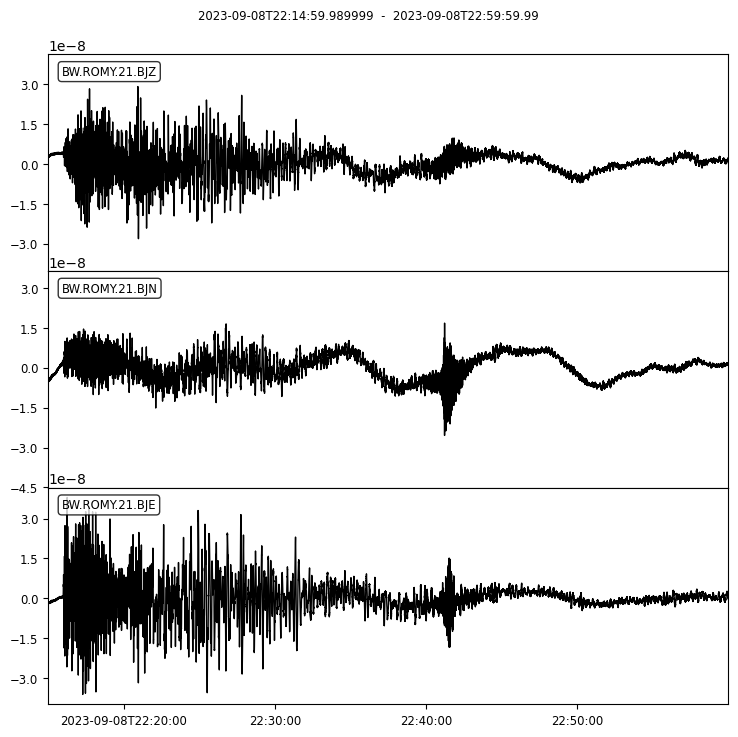

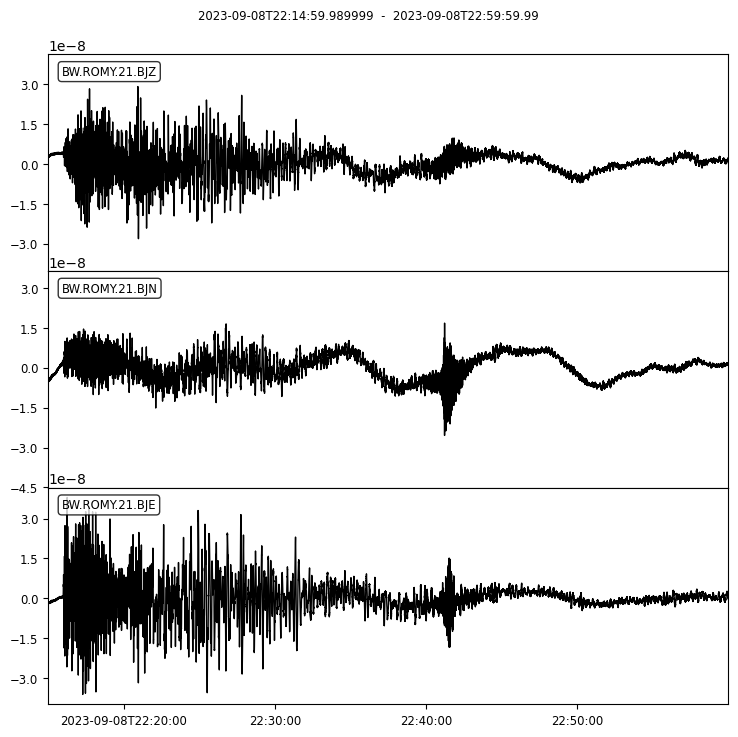

In [21]:
try:
    iadr = __compute_romy_adr(config['tbeg'],
                              config['tend'],
                              submask="inner",
                              ref_station=config['ref_station'],
                              verbose=True,
                              excluded_stations=config['exclude'],
                              map_plot=False,
                             )
    iadr.plot();

except Exception as e:
    print(e)
    iadr = obs.Stream()

 -> load jane inventory GR.FUR ...
 -> obtained waveforms for GR.FUR
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHN | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHE | 2023-09-08T21:14:59.989999Z - 2023-09-08T23:59:59.989999Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.BIB ...
 -> obtained waveforms for BW.BIB
3 Trace(s) in Stream:
BW.BIB..BHZ | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.BIB..BHN | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.BIB..BHE | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.TON ...
 -> obtained waveforms for BW.TON
3 Trace(s) in Stream:
BW.TON..BHZ | 2023-09-08T21:14:59.987500Z - 2023-09-08T23:59:59.987500Z | 20.0 Hz, 198001 samples
BW.TON..BHN | 2023-09-08T21:14:59.987500Z

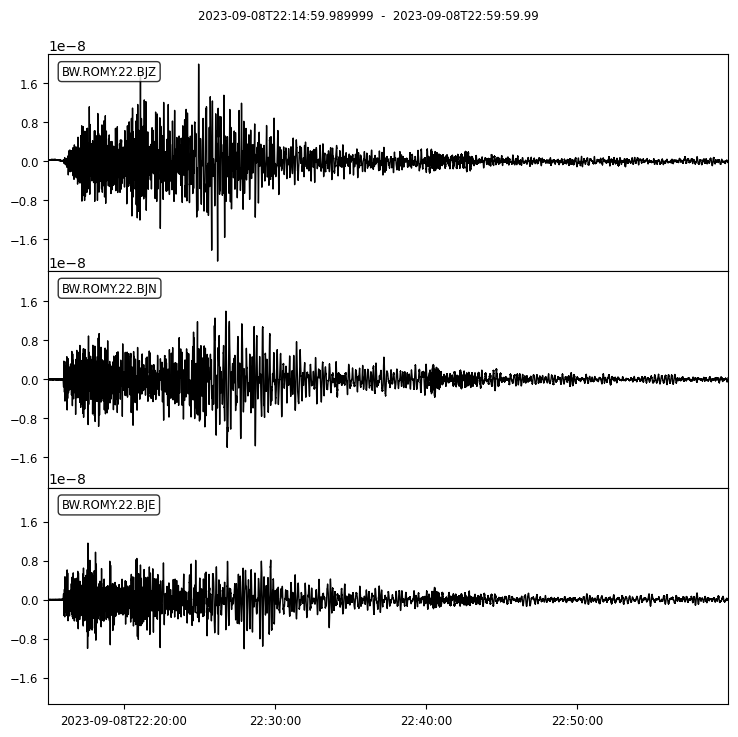

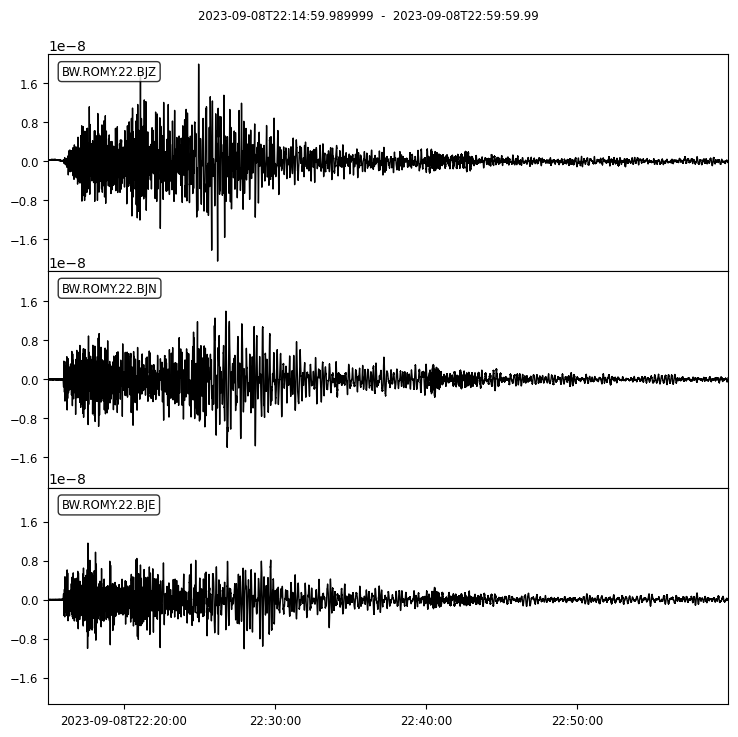

In [22]:
try:
    oadr = __compute_romy_adr(config['tbeg'],
                              config['tend'],
                              submask='outer',
                              ref_station=config['ref_station'],
                              verbose=True,
                              excluded_stations=config['exclude'],
                              map_plot=False,
                             )
    oadr.plot();

except Exception as e:
    print(e)
    oadr = obs.Stream()

 -> load jane inventory GR.FUR ...
 -> obtained waveforms for GR.FUR
3 Trace(s) in Stream:
GR.FUR..BHZ | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHN | 2023-09-08T21:14:59.990000Z - 2023-09-08T23:59:59.990000Z | 20.0 Hz, 198001 samples
GR.FUR..BHE | 2023-09-08T21:14:59.989999Z - 2023-09-08T23:59:59.989999Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.FFB1 ...
 -> obtained waveforms for BW.FFB1
3 Trace(s) in Stream:
BW.FFB1..BHZ | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB1..BHN | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB1..BHE | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
 -> load jane inventory BW.FFB2 ...
 -> obtained waveforms for BW.FFB2
3 Trace(s) in Stream:
BW.FFB2..BHZ | 2023-09-08T21:15:00.000000Z - 2023-09-09T00:00:00.000000Z | 20.0 Hz, 198001 samples
BW.FFB2..BHN | 2023-09-08T21:15:0

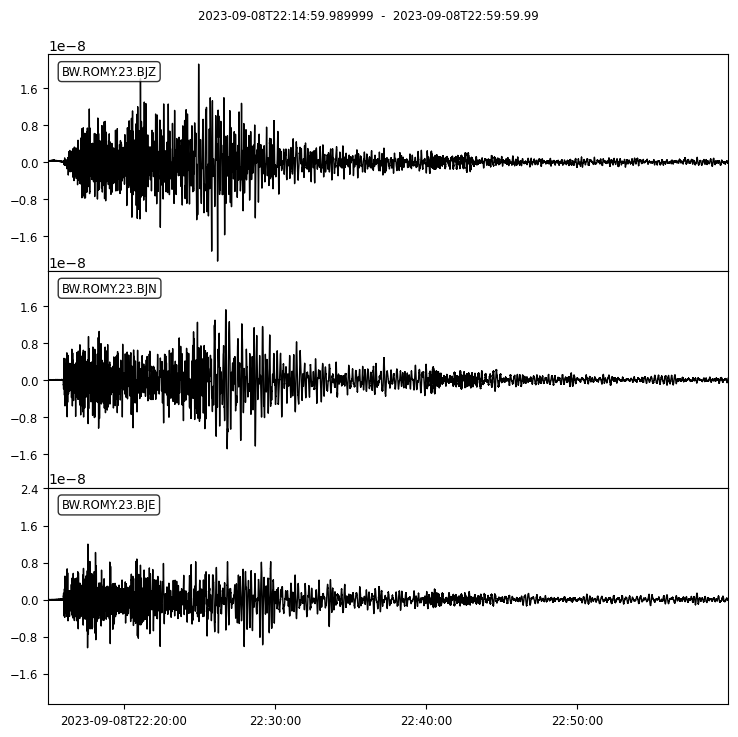

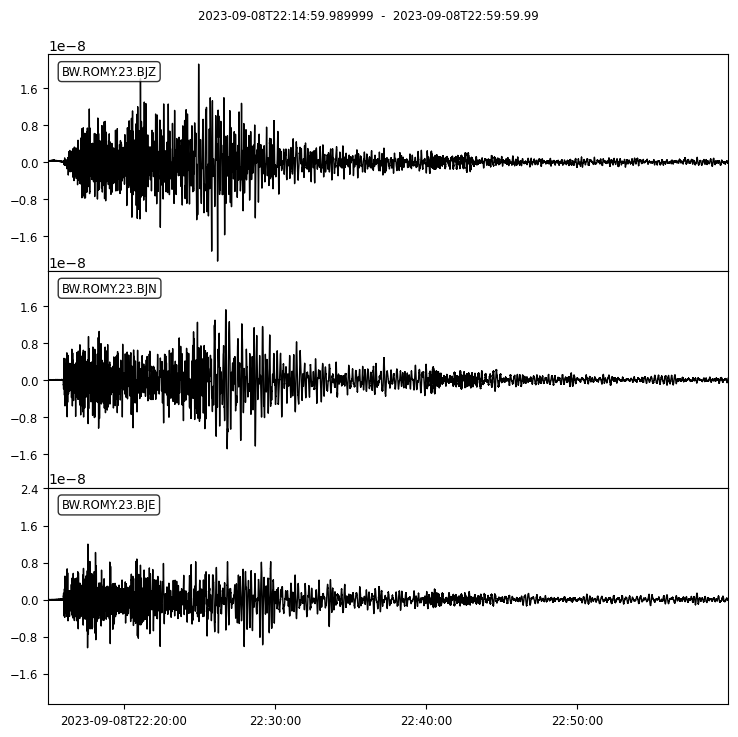

In [23]:
try:
    aadr = __compute_romy_adr(config['tbeg'],
                              config['tend'],
                              submask='all',
                              ref_station=config['ref_station'],
                              verbose=True,
                              excluded_stations=config['exclude'],
                              map_plot=False,
                             )
    aadr.plot();

except Exception as e:
    print(e)
    aadr = obs.Stream()

## Store Data

In [24]:
# try:
#     __write_stream_to_sds(iadr, config['path_to_out_data'])
# except Exception as e:
#     print(e)

In [25]:
# try:
#     __write_stream_to_sds(oadr, config['path_to_out_data'])
# except Exception as e:
#     print(e)

## Load Data

In [26]:
from andbro__read_sds import __read_sds

In [35]:
st00 = obs.Stream()

st00 += __read_sds(archive_path+"temp_archive/", "BW.ROMY.30.BJZ", config['tbeg'], config['tend'])
st00 += __read_sds(archive_path+"temp_archive/", "BW.ROMY.30.BJN", config['tbeg'], config['tend'])
st00 += __read_sds(archive_path+"temp_archive/", "BW.ROMY.30.BJE", config['tbeg'], config['tend'])

st00 += __read_sds(bay_path+"mseed_online/archive/", f"{config['ref_station']}..BHZ", config['tbeg'], config['tend'])
st00 += __read_sds(bay_path+"mseed_online/archive/", f"{config['ref_station']}..BHN", config['tbeg'], config['tend'])
st00 += __read_sds(bay_path+"mseed_online/archive/", f"{config['ref_station']}..BHE", config['tbeg'], config['tend'])

st00 += iadr.copy()
st00 += oadr.copy()
st00 += aadr.copy()

st00 = st00.merge(fill_value=0)

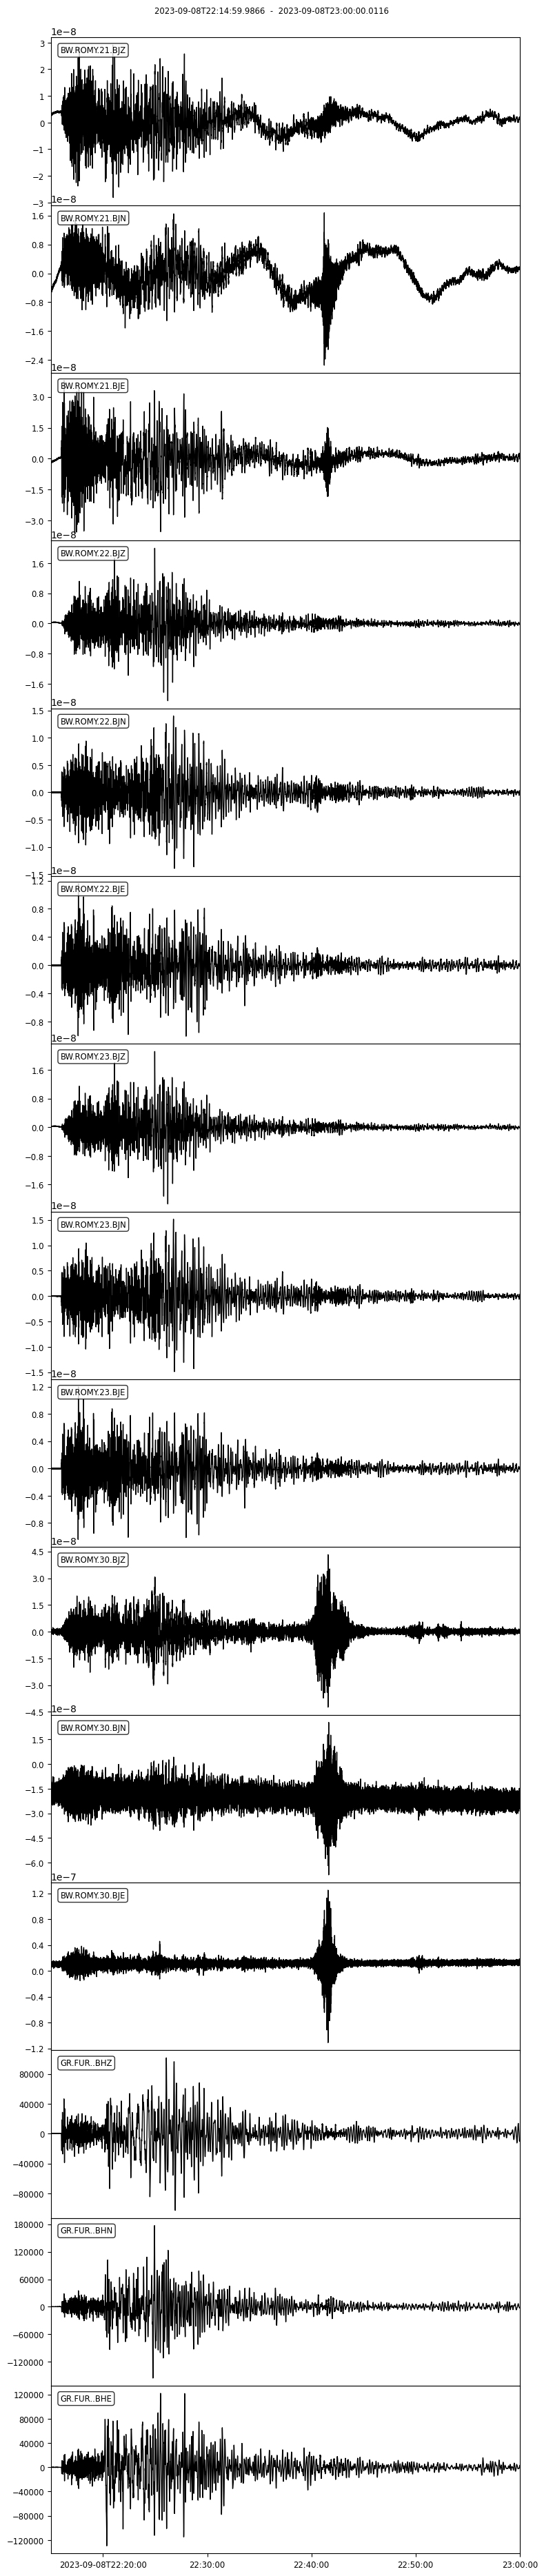

In [36]:
st00.plot(equal_scale=False);

## Inner Array

In [37]:
sti = obs.Stream()
sti += st00.select(station="ROMY", location="30", channel="*J*").copy()
sti += st00.select(station="FUR", location="", channel="*H*").copy()
sti += st00.select(station="ROMY", location="21", channel="*J*").copy()

ifmin, ifmax = 0.1, 0.5
sti = sti.detrend("linear")
sti = sti.taper(0.01, type="cosine")
sti = sti.filter("bandpass", freqmin=ifmin, freqmax=ifmax, corners=4, zerophase=True);

sti.trim(config['tbeg'], config['tbeg']+20*60)

9 Trace(s) in Stream:
BW.ROMY.30.BJE | 2023-09-08T22:14:59.986600Z - 2023-09-08T22:34:59.986600Z | 20.0 Hz, 24001 samples
BW.ROMY.30.BJN | 2023-09-08T22:14:59.999400Z - 2023-09-08T22:34:59.999400Z | 20.0 Hz, 24001 samples
BW.ROMY.30.BJZ | 2023-09-08T22:15:00.011600Z - 2023-09-08T22:35:00.011600Z | 20.0 Hz, 24001 samples
GR.FUR..BHE    | 2023-09-08T22:14:59.989999Z - 2023-09-08T22:34:59.989999Z | 20.0 Hz, 24001 samples
GR.FUR..BHN    | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:34:59.990000Z | 20.0 Hz, 24001 samples
GR.FUR..BHZ    | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:34:59.990000Z | 20.0 Hz, 24001 samples
BW.ROMY.21.BJE | 2023-09-08T22:14:59.989999Z - 2023-09-08T22:34:59.989999Z | 20.0 Hz, 24001 samples
BW.ROMY.21.BJN | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:34:59.990000Z | 20.0 Hz, 24001 samples
BW.ROMY.21.BJZ | 2023-09-08T22:14:59.990000Z - 2023-09-08T22:34:59.990000Z | 20.0 Hz, 24001 samples

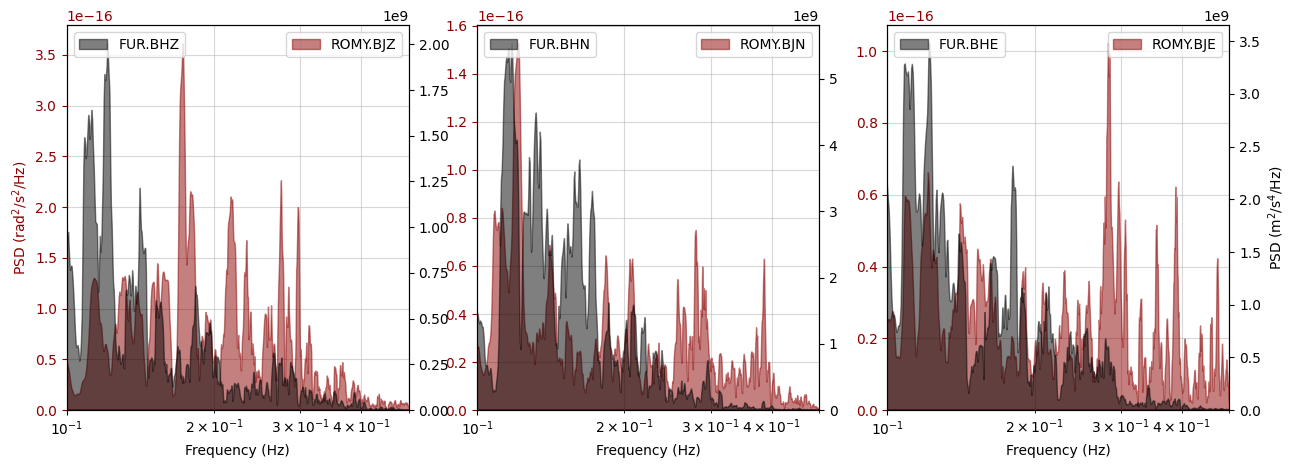

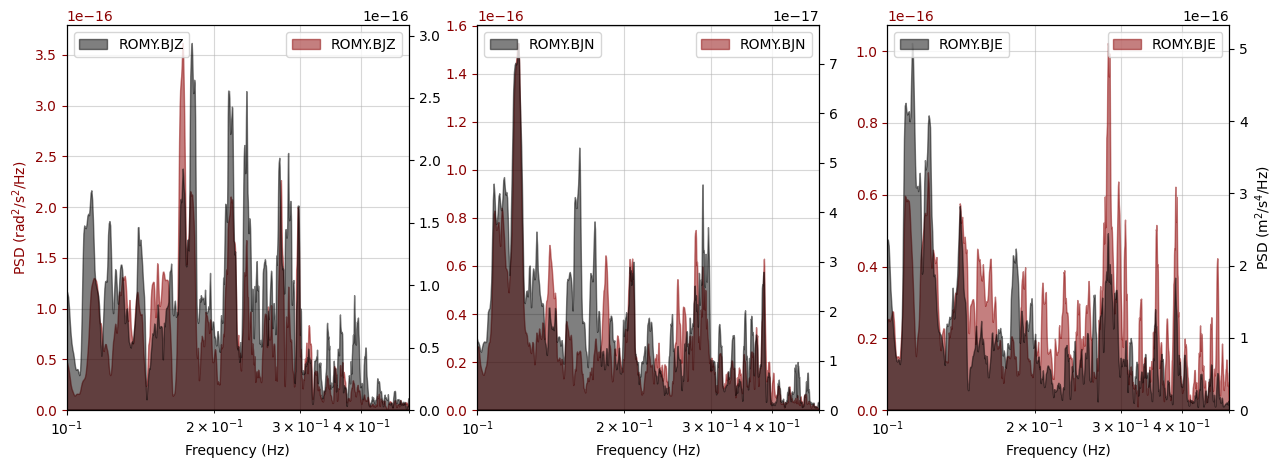

In [38]:
acc0 = sti.select(station="FUR", channel="*H*").copy()
rot0 = sti.select(station="ROMY", channel="*J*", location="3*").copy()
adr0 = sti.select(station="ROMY", channel="*J*", location="2*").copy()

fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=ifmin, fmax=ifmax, ylog=False, xlog=True, fill=True)

fig = __makeplot_spectra_comparison_fill(rot0, adr0, fmin=ifmin, fmax=ifmax, ylog=False, xlog=True, fill=True)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');

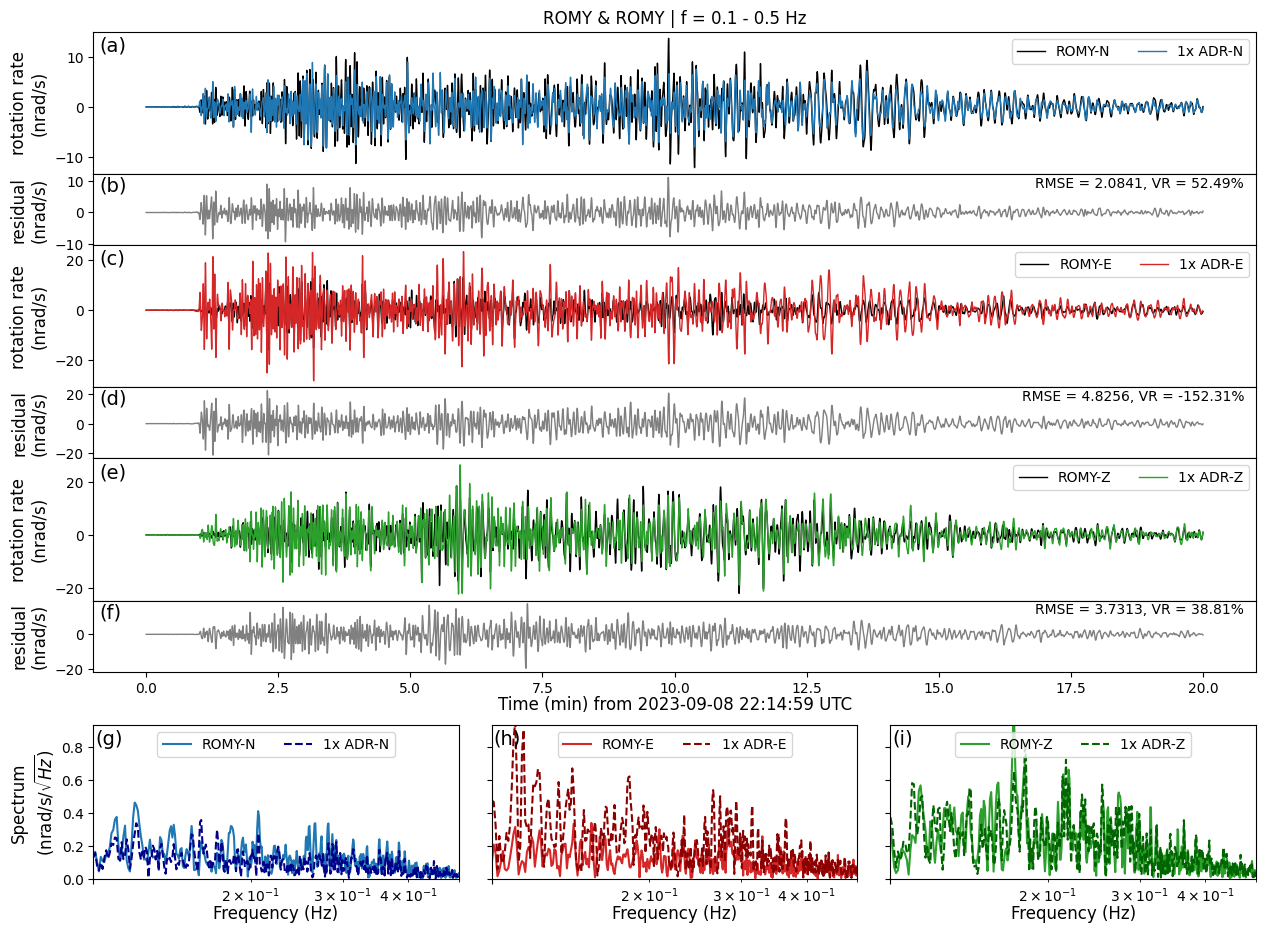

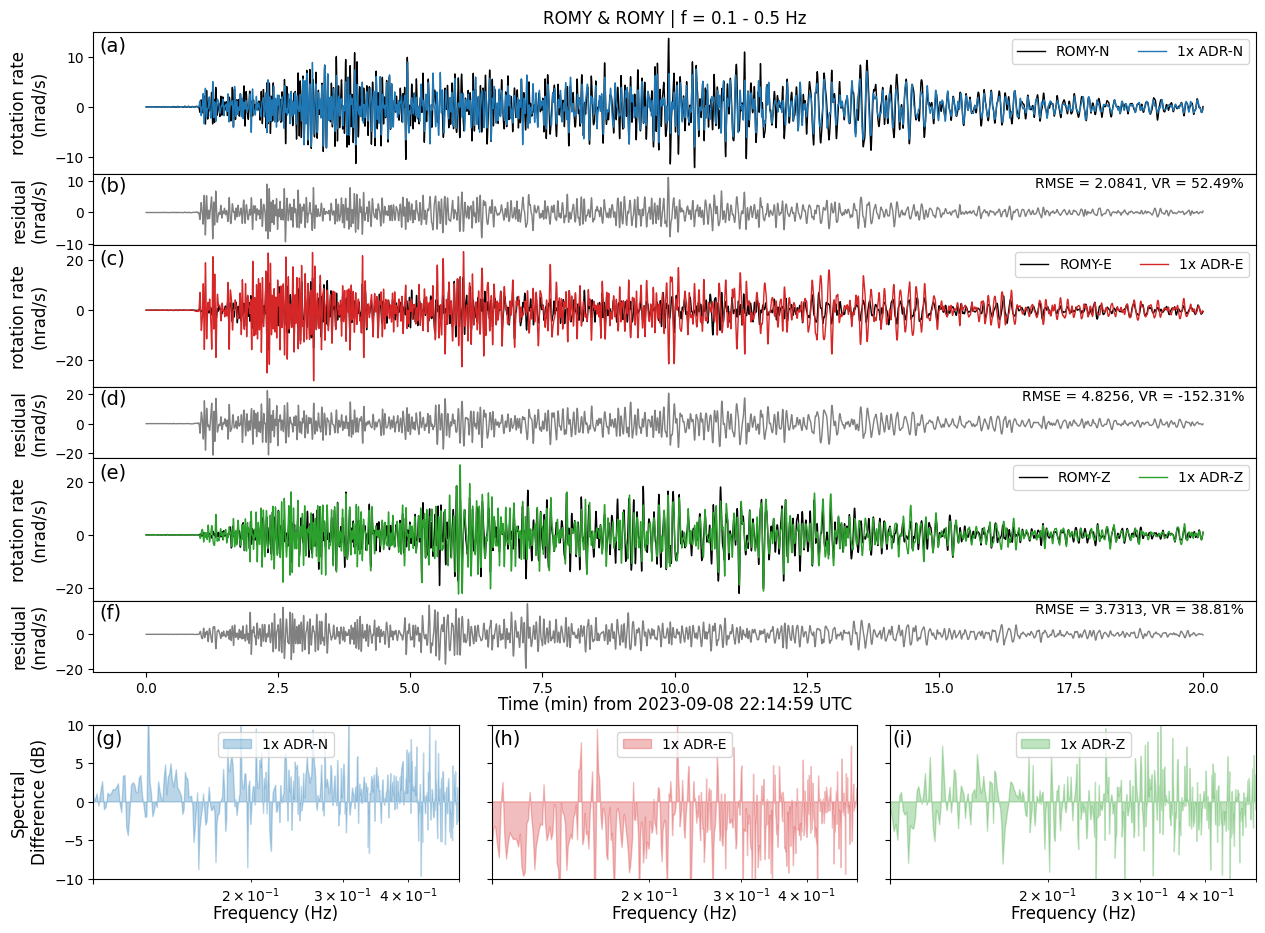

In [39]:
fig = __makeplot_ADR(rot0, adr0, {"N":1, "E":1, "Z":1}, freq=[ifmin, ifmax], flog=False, fill=False)

fig.savefig(config['path_to_figs']+f"RomyArray_ROMYvsADRi_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


fig = __makeplot_ADR(rot0, adr0, {"N":1, "E":1, "Z":1}, freq=[ifmin, ifmax], flog=False, fill=True)

fig.savefig(config['path_to_figs']+f"RomyArray_ROMYvsADRi_{config['tbeg'].date}_fill.png", format="png", dpi=150, bbox_inches='tight')


## Outer Array

In [40]:
sto = obs.Stream()
sto += st00.select(station="ROMY", location="30", channel="*J*").copy()
sto += st00.select(station="FUR", location="", channel="*H*").copy()
sto += st00.select(station="ROMY", location="22", channel="*J*").copy()

ofmin, ofmax = 0.03, 0.1
sto = sto.detrend("linear")
sto = sto.taper(0.01, type="cosine")
sto = sto.filter("bandpass", freqmin=ofmin, freqmax=ofmax, corners=4, zerophase=True);

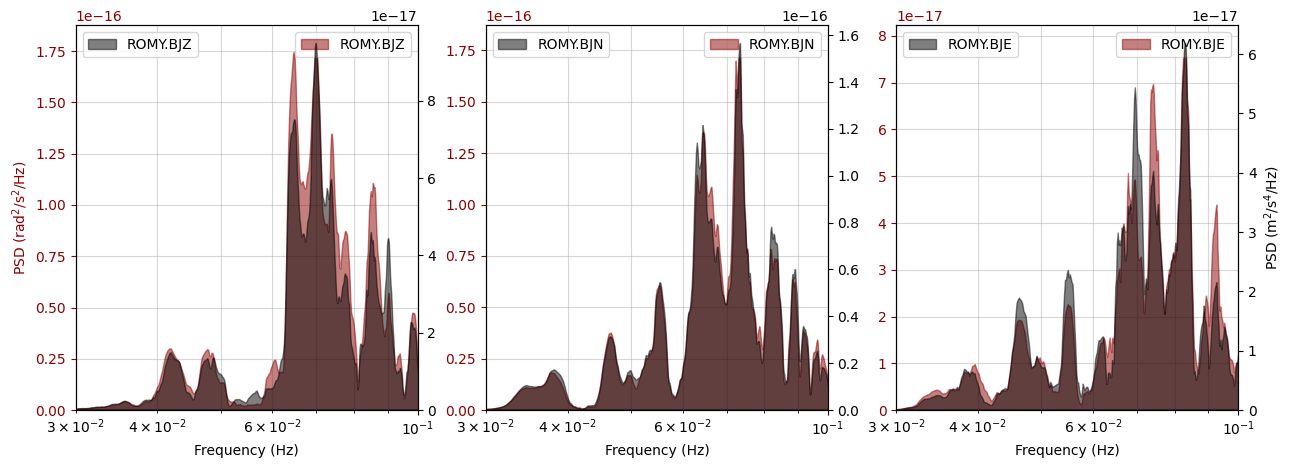

In [41]:
# acc0 = sto.select(station="FUR", channel="*H*").copy()
rot0 = sto.select(station="ROMY", channel="*J*", location="3*").copy()
adr0 = sto.select(station="ROMY", channel="*J*", location="2*").copy()

# fig = __makeplot_spectra_comparison_fill(rot0, acc0, fmin=ofmin, fmax=ofmax, ylog=False, xlog=True, fill=True)

fig = __makeplot_spectra_comparison_fill(rot0, adr0, fmin=ofmin, fmax=ofmax, ylog=False, xlog=True, fill=True)

# fig.savefig(config['path_to_figs']+f"ROMY_{config['event_name']}_spectra_all.png", format="png", dpi=150, bbox_inches='tight');

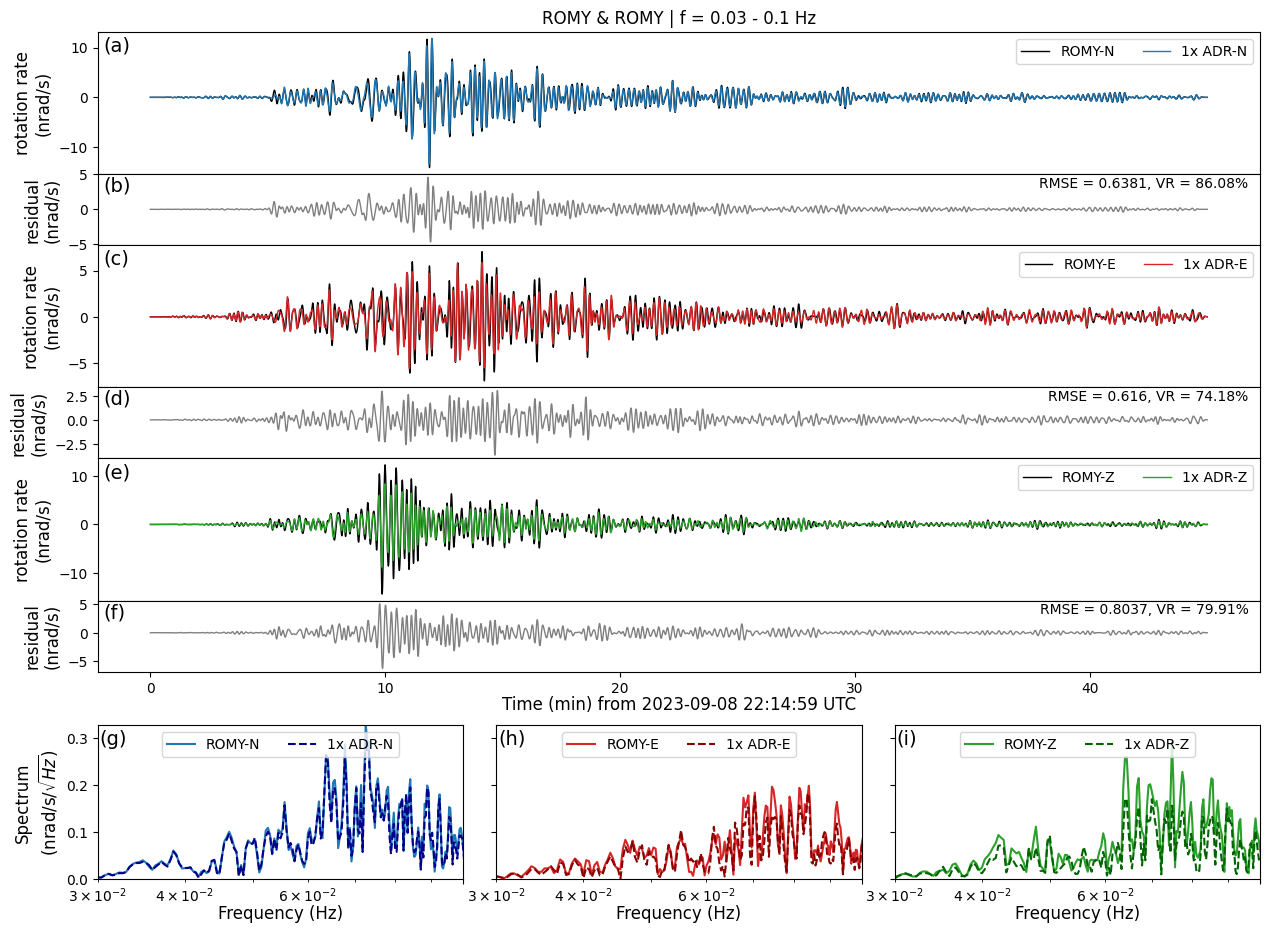

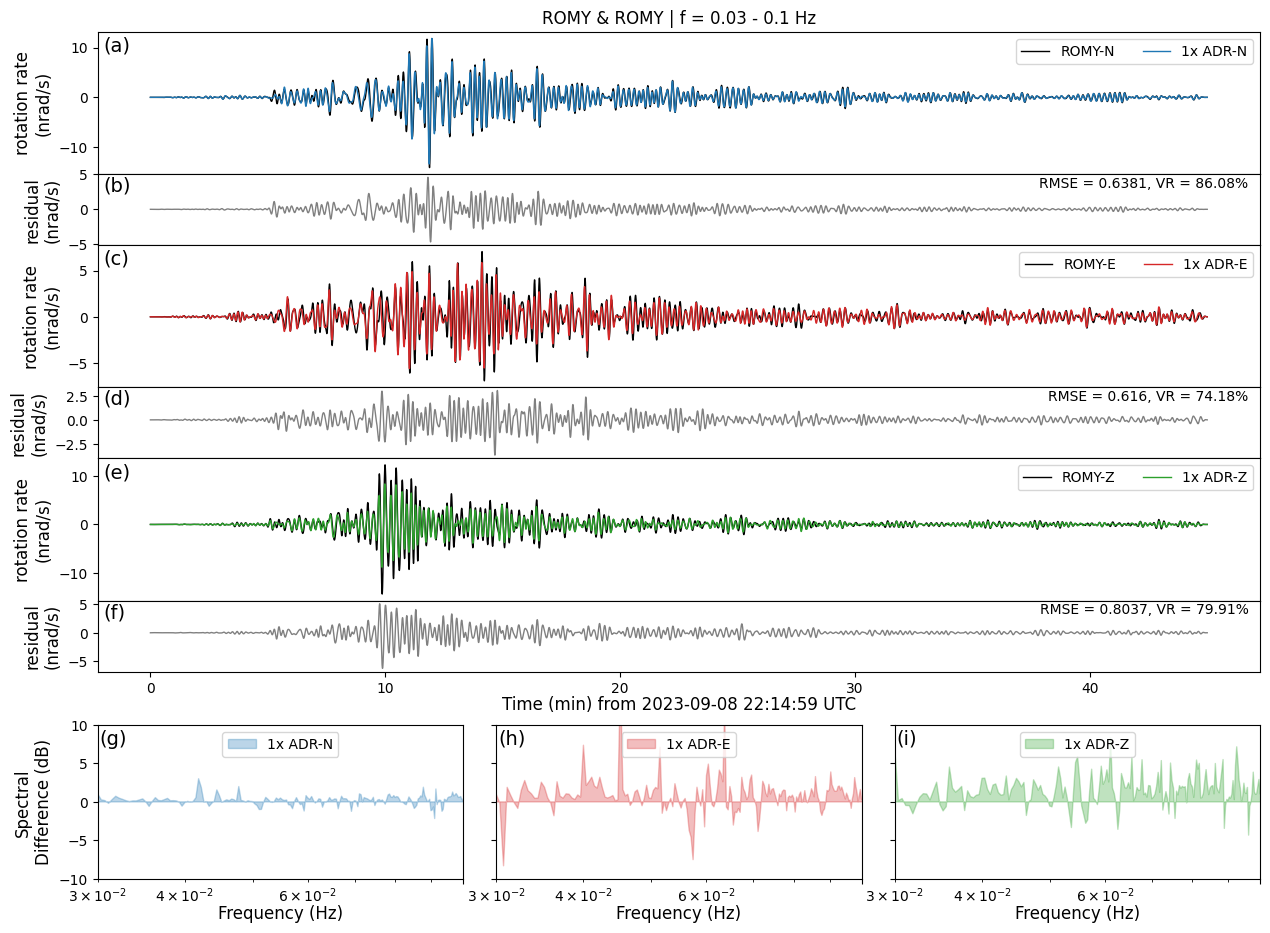

In [42]:
fig = __makeplot_ADR(rot0, adr0, {"N":1, "E":1, "Z":1}, freq=[ofmin, ofmax], flog=False, fill=False)

fig.savefig(config['path_to_figs']+f"RomyArray_ROMYvsADRo_{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')


fig = __makeplot_ADR(rot0, adr0, {"N":1, "E":1, "Z":1}, freq=[ofmin, ofmax], flog=False, fill=True)

fig.savefig(config['path_to_figs']+f"RomyArray_ROMYvsADRo_{config['tbeg'].date}_fill.png", format="png", dpi=150, bbox_inches='tight')


In [43]:
def __makeplot_waveform_comparison(rot, adr, fband):

    from obspy.signal.cross_correlation import correlate
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

    lw = 1.2

    font = 12

    offset = [0, 0, 0]

    plt.subplots_adjust(hspace=0.05)

    scaling, unit = 1e9, f"nrad/s"

    idx = 0

    for _k, comp in enumerate(["Z", "N", "E"]):

        ax[idx].plot(rot.select(channel=f"*{comp}")[0].times(),
                     rot.select(channel=f"*{comp}")[0].data*scaling,
                     label=f"ROMY-{comp}", color="k", lw=lw)
        ax[idx].plot(adr.select(channel=f"*{comp}")[0].times(),
                     adr.select(channel=f"*{comp}")[0].data*scaling,
                     label=f"ADR-{comp}", color="r", lw=lw)

        cc = round(correlate(rot.select(channel=f"*{comp}")[0].data, adr.select(channel=f"*{comp}")[0].data, 0, demean=True, normalize='naive', method='auto')[0], 2)

        # rmse = np.round( np.sqrt( np.mean( ( ( _adr.select(channel=f"*{comp}")[0].data - _bspf.select(channel=f"*{comp}")[0].data )*scaling )**2 ) ), 3)

        ## pick peak rotation velocity
        pgrv = round(np.amax(rot.select(channel=f"*{comp}")[0].data*scaling), 2)

        ## pick peak adr
        padr = round(np.amax(adr.select(channel=f"*{comp}")[0].data*scaling), 2)

        t1 = ax[idx].text(0.01, 0.9, f"{fband[0]}-{fband[1]} Hz", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
        t1.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
        t2 = ax[idx].text(0.15, 0.9, f"CC={cc}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-2)
        t2.set_bbox(dict(facecolor='white', alpha=0.7, linewidth=0))
        t3 = ax[idx].text(0.01, 0.30, f"PGRV={pgrv} {unit}", ha='left', va='top', transform=ax[idx].transAxes, fontsize=font-3)
        t3.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))
        t4 = ax[idx].text(0.01, 0.15, f"PADR={padr} {unit}", ha='left', color="r", va='top', transform=ax[idx].transAxes, fontsize=font-3)
        t4.set_bbox(dict(facecolor='white', alpha=0., linewidth=0))

        ax[idx].legend(loc=1, ncols=4, fontsize=font-2)

        # ax[idx].grid(which="both", alpha=0.5)

        ax[idx].set_ylabel(f"$\Omega$ ({unit})", fontsize=font)
        ax[idx].xaxis.label.set_size(font-1)
        ax[idx].yaxis.label.set_size(font-1)

        if idx < 8:
            ax[idx].tick_params(axis='x', bottom=False)

        for pos in ["right", "top", "bottom"]:
            ax[idx].spines[pos].set_visible(False)

        idx += 1

    ax[idx-1].spines["bottom"].set_visible(True)

    ax[idx-1].set_xlabel(f"Time (s) from {rot[0].stats.starttime.date} {str(rot[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)

    # ax[0].set_title(f"{config['tbeg'].date} | {config['fmin']}-{config['fmax']} Hz | ADR {submask} | CC$_Z$ = {cc_Z} | CC$_N$ = {cc_N} | CC$_E$ = {cc_E}")

    plt.show();
    return fig

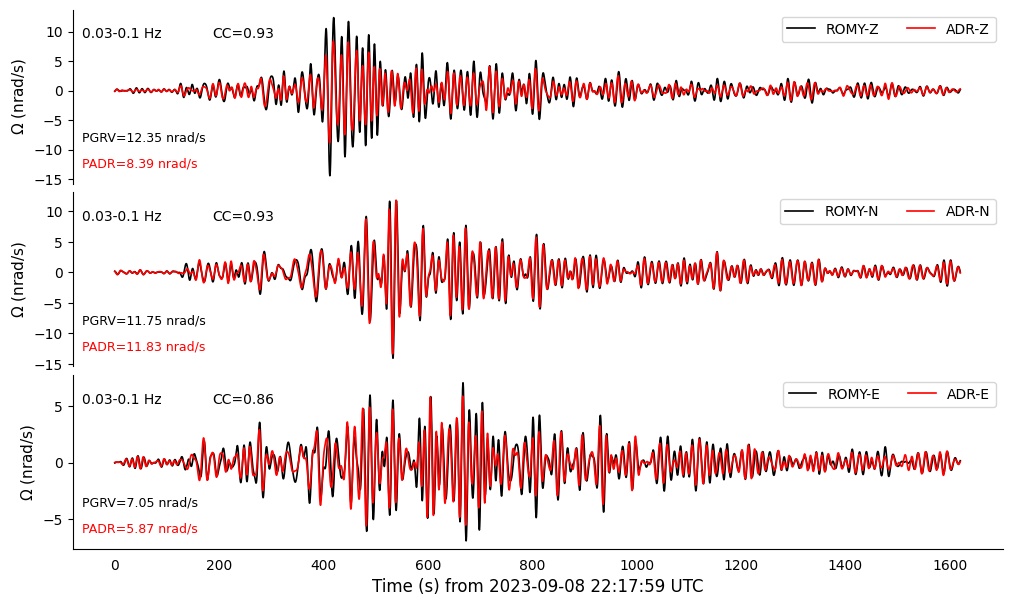

In [50]:
stx = sto.copy()

# stx = stx.trim(config['tbeg']+1800, config['tend'])
stx = stx.trim(config['tbeg']+180, config['tend']-900)

l_min = min([len(tr.data) for tr in stx])
for tr in stx:
    tr.data = tr.data[:l_min]

fig = __makeplot_waveform_comparison(stx.select(location="30"), stx.select(location="22"), [ofmin, ofmax]);

fig.savefig(config['path_to_figs']+f"RomyArray_ROMYvsADR_{config['tbeg'].date}_waveforms.png", format="png", dpi=150, bbox_inches='tight')
